In [41]:
import numpy as np
import matplotlib.pyplot as plt
import json
from RSan.Hurst import hurst #implementacja R/S z githuba
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

Tworzenie danych. makenew->True jeśli chcemytworzyć dane

Parametr n liczba iteracji w generatorze czyli 2^n określa długość pojedyńczego szeregu

Parametr s elementów ma być zrobionych dla każdej z 11 klas

Filename nazwa pliku do którego zapisujemy dane (i odczytujemy)
PS: pliki z danymi są za duże żeby wysłać je na githuba , domyślnie były to pliki z generatora z parametrami

small.txt n=9 s=500

big.txt n=12 s=500

testRS.txt n=9 s=100

In [119]:
import gen
makenew=False
filename='small.txt'

In [120]:
%%time


if(makenew==True):
    print("Rozmiar produkowanych danych:")
    print(gen.makedata(filename,n=9,s=100))
else:
    print("Nie wczytano nowych danych")

Nie wczytano nowych danych
CPU times: user 1.83 ms, sys: 6 µs, total: 1.84 ms
Wall time: 1.15 ms


In [121]:
%time
#wczytywanie danych
with open(filename) as json_file:
    data = json.load(json_file)
    #for row in data:
        #print(row)
print("Rozmiar wczytanych danych:",len(data))

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 9.78 µs
Rozmiar wczytanych danych: 5500


Korzystając implementcji R/S, można sprawdzić czy generator danych rzeczywiście jest sensowny. Algortym jest dość wolny więc warto testować na około małych danych (512) i niezbyt wielu próbkach. Przykladowo jest testRS.txt

In [118]:
testuj=True
if(testuj):
    with open('testRS.txt') as json_file:
        test_data= json.load(json_file)
    %time wyniki=np.array([ (hurst(ts),v) for ts,v in test_data])
    h,v=wyniki[:,0],wyniki[:,1]
    vg=np.unique(v)
    grouped_measurements=[]
    for el in vg:
        idx=np.where(v==el)
        grouped_measurements.append(h[idx])
    #rint(grouped_measurements)
    grouped_measurements=np.array(grouped_measurements)
    odchylka=np.abs(np.mean(grouped_measurements,axis=1)-vg )
    print("Odchylenie średniej pomiarów od wartości teoretycznej,w pierwszej kolumnie odchyłka, w drugiej wartość teoretyczna:")
    for el ,kl in zip(odchylka,vg):
        print(el, kl)

CPU times: user 10min 53s, sys: 17 s, total: 11min 11s
Wall time: 9min 5s
Odchylenie średniej pomiarów od wartości teoretycznej,w pierwszej kolumnie odchyłka, w drugiej wartość teoretyczna:
0.0004451829597773571 0.5099999961128131
0.0060252124937558715 0.5499999897951613
0.001407038976895758 0.6000001100931586
0.004212532299559535 0.6499998725548443
0.036450088801563085 0.7000000511222686
0.023844834053999286 0.7500000382985316
0.04974436474381194 0.8000003928798565
0.07050512518134933 0.8500000102188451
0.07384137577630356 0.8999999450303935
0.11075532109432862 0.949999978597738
0.11132918928139512 0.990000012853072


# RandomForestClassifier

In [100]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import sklearn
from sklearn.model_selection import cross_val_score,cross_validate

In [101]:
#Przygotowanie danych
dane=np.array(data)
v=np.unique(dane[0:,1])
d=dict(zip(v,np.arange(v.shape[0])))
#print(d)
expected=dane[:,1]
y=[d[el] for el in expected]
X=dane[:,0].tolist()
X_train, X_test,y_train, y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)
#print(X_train,y_train,"\n\n",X_test,y_test)

Przeszukiwanie podprzestrzeni parametrów

In [102]:
%%time
make=False
#Grid search lepiej napisać własny z pythonowym są problemy
if(make):
    model=RandomForestClassifier()
    from sklearn.model_selection import ParameterGrid
    param_grid=[{'n_estimators':[10,20,100,200],'max_depth':[10,20,40,100],
                                         'max_leaf_nodes':[10,20,40,100],
                                         'max_features':[0.6,0.8,1],
                                         #'min_weight_fraction_leaf'=0.001,
                                         'bootstrap':[True],
                                         }]
    results={}
    for dic in ParameterGrid(param_grid):
        print(dic)
        model.set_params(**dic)
        ac=np.mean(cross_val_score(model,X,y,error_score='raise',scoring='accuracy',cv=3))
        results[ac]=dic
    for el in sorted(results.keys()):
        print(el,results[el])

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 17.9 µs


In [103]:
rfc =RandomForestClassifier(random_state=0,\
                                     max_depth=60,\
                                     max_leaf_nodes=80,\
                                     n_estimators=300,\
                                     max_features=1,\
                                     criterion="gini",\
                                     min_samples_split=30,
                                     #min_samples_leaf=0.005,\
                                     bootstrap=True,
                                     #n_jobs=-1,
                                     oob_score=True)

#Najlepsze wyniki GridSearch wyszło że takie są najlepsze.
#0.807111111111111 { 'max_depth': 20, 'max_features': 0.8, 'max_leaf_nodes': 100, 'n_estimators': 200}
#0.8088888888888889 { 'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': 100, 'n_estimators': 100}
#0.8124444444444444 { 'max_depth': 40, 'max_features': 1, 'max_leaf_nodes': 100, 'n_estimators': 100}
#0.8242222222222222 {'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': 100, 'n_estimators': 200}
#0.8242222222222223 { 'max_depth': 100, 'max_features': 1, 'max_leaf_nodes': 100, 'n_estimators': 200}
#0.8255555555555555 { 'max_depth': 40, 'max_features': 1, 'max_leaf_nodes': 100, 'n_estimators': 200}

Crossvalidacja  wraz z odchyleniem standardowym

In [104]:

%time scores=cross_val_score(rfc,X,y,error_score='raise',scoring='accuracy',cv=5)
print(np.mean(scores),np.std(scores))

CPU times: user 16 s, sys: 59.9 ms, total: 16 s
Wall time: 16.1 s
0.8207272727272727 0.011969658611369298


In [105]:
%time model=rfc.fit(X_train,y_train)
print("Wstępnie przewidywana dokladnosc:",model.oob_score_)

CPU times: user 2.89 s, sys: 3.98 ms, total: 2.89 s
Wall time: 2.89 s
Wstępnie przewidywana dokladnosc: 0.8052272727272727


Analiza wytrenowanego modelu

In [106]:
#Sprawdzanie modelu na zbiorze treningowym
print("Dokładnosc na zbiorze treningowym:")
y_pred=model.predict(X_train)
ac=sklearn.metrics.accuracy_score(y_train, y_pred, normalize=True, sample_weight=None)

print("Accuracy modelu wynosi",ac)


print("Dokładnosc na zbiorze testowym:")
y_pred=model.predict(X_test)
ac=sklearn.metrics.accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
print("Accuracy modelu wynosi",ac)

Dokładnosc na zbiorze treningowym:
Accuracy modelu wynosi 0.9240909090909091
Dokładnosc na zbiorze testowym:
Accuracy modelu wynosi 0.81


Model udostępnia statystyki tego jak bardzo użyteczna jest każda waga. Poniżej wizualizacja wag.

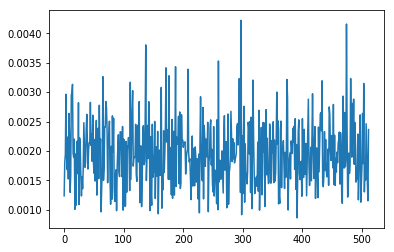

In [107]:
plt.plot(model.feature_importances_)

Model można zwizualizować (dokładniej jedno z składowych drzew)

In [108]:
import pydotplus
from IPython.display import Image
from sklearn import tree

nr_drzewa=np.random.randint(len(model.estimators_))
estimator=model.estimators_[nr_drzewa]
dot_data=tree.export_graphviz(estimator,out_file=None)
graph=pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())
graph.write_pdf("treeclas.pdf")

True

# RandomForestRegressor

In [109]:
#Dla regresora trzeba podawać output prawdziwy a nie klase
dane=np.array(data)
y2=dane[:,1].tolist()
X2=dane[:,0].tolist()
X2_train, X2_test,y2_train, y2_test=sklearn.model_selection.train_test_split(X2,y2,test_size=0.2)

In [23]:
%%time
#Grid search lepiej napisać własny z pythonowym są problemy
#Tu są wyniki z robienia gridsearcha dla danych dlugosci 512 po 450 na każdą klasę.
make=False
if(make):
    scorer=sklearn.metrics.make_scorer(acc, greater_is_better=True)
    #print(scorer(model,X2_test,y2_test))
    model=RandomForestRegressor()
    from sklearn.model_selection import ParameterGrid
    param_grid=[{'n_estimators':[10,20,100,200],'max_depth':[10,20,40],
                                         'max_leaf_nodes':[10,20,40],
                                         #'max_features':[0.8,1],
                                         #'min_weight_fraction_leaf'=0.001,
                                         'n_jobs':[-1]
                                         }]
    results={}
    p=np.random.permutation(len(X))
    Xp=np.array(X2)[p].tolist()
    yp=np.array(y2)[p].tolist()
    for dic in ParameterGrid(param_grid):
        print(dic)
        model.set_params(**dic)
        ac=np.mean(cross_val_score(model,Xp,yp,scoring=scorer,cv=3))
        results[ac]=dic
        print(ac)
    for el in sorted(results.keys()):
        print(el,results[el])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [110]:
rfreg =RandomForestRegressor(random_state=0,\
                                     max_depth=60,\
                                     max_leaf_nodes=80,\
                                     n_estimators=300,\
                                     max_features=0.8,\
                                     min_samples_split=30,
                                     #min_samples_leaf=0.01,\
                                     bootstrap=True,
                                     #n_jobs=-1,
                                     )  
#Najlepsze wyniki z Grid search
#0.7997777777777778 {'max_depth': 20, 'max_leaf_nodes': 40, 'n_estimators': 100, 'n_jobs': -1}
#0.802888888888889 {'max_depth': 10, 'max_leaf_nodes': 40, 'n_estimators': 100, 'n_jobs': -1}
#0.8068888888888889 {'max_depth': 40, 'max_leaf_nodes': 40, 'n_estimators': 200, 'n_jobs': -1}
#0.8075555555555556 {'max_depth': 10, 'max_leaf_nodes': 40, 'n_estimators': 200, 'n_jobs': -1}
#0.8097777777777777 {'max_depth': 20, 'max_leaf_nodes': 40, 'n_estimators': 200, 'n_jobs': -1}

In [92]:
#crossvalidacja

scorer=sklearn.metrics.make_scorer(acc, greater_is_better=True)
#print(scorer(model,X2_test,y2_test))
p=np.random.permutation(len(X2))
Xp=np.array(X2)[p]
yp=np.array(y2)[p]
%time scores=cross_val_score(rfreg,Xp,yp,scoring=scorer,cv=3)
#print(scores)
print(np.mean(scores),np.std(scores))

KeyboardInterrupt: 

0.8081818181818182 0.015587661999529323


In [111]:
%time model=rfreg.fit(X2_train,y2_train)

CPU times: user 4min 23s, sys: 144 ms, total: 4min 23s
Wall time: 4min 24s


Analiza modelu

In [112]:
#szybki sposób na sprawdzenie dokładnosci modelu dla regression tree
#PRzygotowanie danych2

print("Dokładnosc na zbiorze treningowym")
def acc(a,b): #wlasny scorer
    tol=0.025
    w=np.abs(a-b)
    wyn=np.sum(np.where(w<tol,1,0))/len(a)
    #print(wyn)
    return wyn

y2_pred=np.array(model.predict(X2_train))

ac=acc(y2_train, y2_pred)

print("Accuracy modelu wynosi",ac)

print("Dokładnosc na zbiorze testowym")
y2_pred=model.predict(X2_test)
ac=acc(y2_test, y2_pred)
print("Accuracy modelu wynosi",ac)

Dokładnosc na zbiorze treningowym
Accuracy modelu wynosi 0.9525
Dokładnosc na zbiorze testowym
Accuracy modelu wynosi 0.8536363636363636


Wizualizacja wartosci wag.

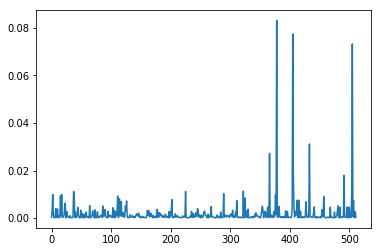

In [113]:
plt.plot(model.feature_importances_)

In [114]:
#random forest visualization
#Zabawa z Decision tRee Classifier
import pydotplus
from IPython.display import Image
from sklearn import tree
estimator=model.estimators_[5]
dot_data=tree.export_graphviz(estimator,out_file=None)
graph=pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())
graph.write_pdf("treereg.pdf")

True

# Podsumowanie
Ostateczny trening i test modeli 

In [71]:
model1 =RandomForestClassifier(random_state=0,\
                                     max_depth=60,\
                                     max_leaf_nodes=80,\
                                     n_estimators=300,\
                                     max_features=1,\
                                     criterion="gini",\
                                     #min_samples_split=30,
                                     #min_samples_leaf=0.005,\
                                     bootstrap=True,
                                     #n_jobs=-1,
                                     )

model2 =RandomForestRegressor(random_state=3,\
                                     max_depth=60,\
                                     max_leaf_nodes=80,\
                                     n_estimators=300,\
                                     max_features=0.8,\
                                     min_samples_split=30,
                                     #min_samples_leaf=0.01,\
                                     bootstrap=True,
                                     #n_jobs=-1,
                                     )  

In [128]:
#wczytanie danych
def prepare(filename):
    with open(filename) as json_file:
        datasmall = json.load(json_file)
        #for row in data:
            #print(row)
    dane=np.array(datasmall)
    v=np.unique(dane[0:,1])
    d=dict(zip(v,np.arange(v.shape[0])))
    expected=dane[:,1]
    y=[d[el] for el in expected]
    X=dane[:,0].tolist()
    y2=dane[:,1].tolist()
    X2=dane[:,0].tolist()
    #crossvalidacja  wraz z odchyleniem standardowym
    
    return X,y,X2,y2

def acc(a,b): #wlasny scorer
        tol=0.025
        w=np.abs(a-b)
        wyn=np.sum(np.where(w<tol,1,0))/len(a)
        #print(wyn)
        return wyn
scorer=sklearn.metrics.make_scorer(acc, greater_is_better=True)
danesmall=prepare('small.txt')
danebig=prepare('big.txt')

Dane male (długość szeregu 512)

In [129]:
X,y,X2,y2=danesmall
p=np.random.permutation(len(X2))
X2=np.array(X2)[p]
y2=np.array(y2)[p]

In [75]:
%time scores=cross_val_score(model1,X,y,error_score='raise',scoring='accuracy',cv=3)
print("Dokładność modelu1 na malych danych:",np.mean(scores),"\u00B1",np.std(scores))
%time scores=cross_val_score(model2,X2,y2,scoring=scorer,cv=3)
print("Dokładność modelu2 na malych danych:",np.mean(scores),"\u00B1",np.std(scores))

CPU times: user 4.74 s, sys: 4 ms, total: 4.75 s
Wall time: 4.75 s
Dokładność modelu1 na malych danych: 0.8187218115794698 ± 0.0027800229847596454
CPU times: user 9min 51s, sys: 162 ms, total: 9min 51s
Wall time: 9min 51s
Dokładność modelu2 na malych danych: 0.8479977424268474 ± 0.011033175411015164


Dane duże (długość szerego 4096)

In [76]:
X,y,X2,y2=danebig
p=np.random.permutation(len(X2))
X2=np.array(X2)[p]
y2=np.array(y2)[p]

In [77]:

%time scores=cross_val_score(model1,X,y,error_score='raise',scoring='accuracy',cv=3)
print("Dokładność modelu1 na malych danych:",np.mean(scores),"\u00B1",np.std(scores))
%time scores=cross_val_score(model2,X2,y2,error_score='raise',scoring=scorer,cv=3)
print("Dokładność modelu2 na malych danych:",np.mean(scores),"\u00B1",np.std(scores))

CPU times: user 8.86 s, sys: 4.02 ms, total: 8.86 s
Wall time: 8.87 s
Dokładność modelu1 na malych danych: 0.8320073981281686 ± 0.0031626626496389283
CPU times: user 1h 37min 41s, sys: 2.38 s, total: 1h 37min 44s
Wall time: 1h 37min 51s
Dokładność modelu2 na malych danych: 0.9236359619663177 ± 0.003487519627779838


Test dla danych z nilu

In [206]:
d={0:0.51 , 1:0.55, 2:0.6 , 3:0.65, 4:0.7 , 5:0.75, 6:0.8 , 7:0.85, 8:0.9 , 9:0.95, 10:0.99}

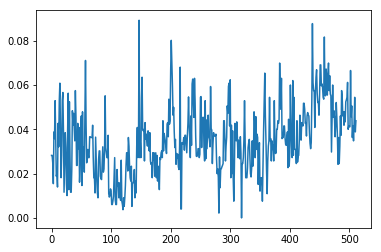

512


In [194]:
import csv
nile_data=[]
with open('nile', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ')
    for row in spamreader:
        for el in row:
            nile_data.append(int(el))
#print(nile_data)
y=np.array(nile_data)
y=y/np.linalg.norm(y)
y=y-np.min(y)
y=y/np.linalg.norm(y)
start=40
y_cut=y[start:start+512]
#x=np.arange(622,1285)
plt.plot(y_cut)
#plt.xlabel('')
plt.show()


print(len(y_cut))
#print(dfa((nile_data) )[2])
#print(hurst(nile_data)
#print(y.tolist())

In [208]:
modelsmall=model1.fit(danesmall[0],danesmall[1])
d[modelsmall.predict([y_cut])[0]]
#10 klasa czyli (0.975,0.99)

0.95

In [135]:
hurst(y_cut)

0.8932186843580985

AirQuality

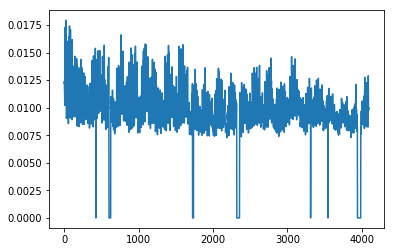

In [237]:
import csv
airdata=[]
with open('AirQualityUCI/AirQualityUCI.csv', newline="\n") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    next(spamreader, None)  # skip the headers
    for row in spamreader:
        airdata.append(row)
#print(airdata)
y=np.array(airdata)
ts=y[:,3]
#print(ts)
todelete=[]
ts=ts.astype(int, order='K', casting='unsafe', subok=True, copy=True)
ts=ts-np.min(ts)
ts=ts/np.linalg.norm(ts)
start=100
y_cut=ts[start:start+4096]

plt.plot(y_cut)
#plt.xlabel('')
plt.show()


#print(len(y_cut))
#print(dfa((nile_data) )[2])
#print(hurst(nile_data)
#print(y.tolist())

In [238]:
#model1=model1.fit(danebig[0],danebig[1])
#model2=model2.fit(danebig[2],danebig[3])
print(d[model1.predict([y_cut])[0]])
print(model2.predict([y_cut]))
#10 klasa czyli (0.975,0.99)

0.99
[0.976]


In [189]:
ts_t=y_cut+4
ts_t=ts_t/np.linalg.norm(ts_t)
hurst(ts_t)

0.7046084230311686